**Crop classification with CNN using Sentinel-2 imagery**

In [ ]:
import pandas as pd, os
ROOT="/content/drive/MyDrive/parcel_centric"
for sp in ["train","val","test"]:
    df = pd.read_csv(f"{ROOT}/indices/parcel_{sp}.csv")
    print(sp, df["class_id"].value_counts().sort_index().to_dict())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/parcel_centric/indices/parcel_train.csv'

#Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# == 2) Install geospatial stack (requires restart) ==
# If you hit binary/ABI issues, first clean conflicting builds:
# !pip -q uninstall -y rasterio geopandas shapely fiona pyproj pyogrio rtree numpy

!pip -q install "numpy==1.26.4"
!pip -q install "rasterio==1.3.9" "geopandas==0.14.3" "pyproj==3.6.1" \
                "shapely==2.0.3" "fiona==1.9.5" "pyogrio==0.7.2" rtree

import os
print("✅ Installed. Restarting runtime...")
os.kill(os.getpid(), 9)  # <-- runtime restarts here


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 126.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.7/20.7 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# == 3) Verify environment versions ==
import sys, numpy as np, rasterio, geopandas as gpd, shapely, fiona, pyproj, pyogrio
print("Python:", sys.version)
print("NumPy:", np.__version__)
print("rasterio:", rasterio.__version__)
print("geopandas:", gpd.__version__)
print("shapely:", shapely.__version__)
print("fiona:", fiona.__version__)
print("pyproj:", pyproj.__version__)
print("pyogrio:", pyogrio.__version__)

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
NumPy: 1.26.4
rasterio: 1.3.9
geopandas: 0.14.3
shapely: 2.0.3
fiona: 1.9.5
pyproj: 3.6.1
pyogrio: 0.7.2


Ορισμός RΟΟΤ φακέλου & συγχρονισμός Sentinel-2 σε τοπικό SSD

In [ ]:
# == 4) Paths, imports, and S2 cache ==
import os, sys, numpy as np, rasterio, geopandas as gpd

ROOT = "/content/drive/MyDrive/parcel_centric"
SRC  = f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)

print("ROOT:", ROOT)
print("NumPy:", np.__version__)

# (Optional) copy Sentinel-2 month_* folders locally for speed
!rsync -ah --info=progress2 "{ROOT}/sentinel_data/" "/content/s2_cache/" || true
!find /content/s2_cache -maxdepth 1 -type d -name "month_*" -printf "%f\n" | sort

ROOT: /content/drive/MyDrive/parcel_centric
NumPy: 1.26.4
          5.61G 100%   31.98MB/s    0:02:47 (xfr#60, to-chk=0/71)
month_01
month_02
month_03
month_04
month_05
month_06
month_07
month_08
month_09
month_10


Make template (10 m grid) + check

In [ ]:
# == 5) Make template grid ==
!python "{SRC}/00_make_template.py"

import rasterio, os
tpl = os.path.join(ROOT, "data/grid/template.tif")
with rasterio.open(tpl) as ds:
    print("Template:", (ds.height, ds.width), "| res:", ds.res, "| CRS:", ds.crs)


Template: /content/drive/MyDrive/parcel_centric/data/grid/template.tif
Template: (10980, 10980) | res: (10.0, 10.0) | CRS: EPSG:32634


select the parcels from 20 classes (386522 / 405862)

In [ ]:
# == 6) Filter parcels ==
!python "{SRC}/01_filter_parcels.py"

import geopandas as gpd, os
gdf = gpd.read_file(f"{ROOT}/data/parcels/parcels_filtered.gpkg")
print("Parcels:", len(gdf), "| CRS:", gdf.crs)
print("Per-class (0..19):", gdf["label_id"].value_counts().sort_index().to_dict())


Found layers: ['Parcels_2023']
Using overrides: layer='Parcels_2023', field='Κωδικοί_Καλλιέργειας'
Filtered parcels saved: /content/drive/MyDrive/parcel_centric/data/parcels/parcels_filtered.gpkg | rows: 386522 / 405862
Per-class counts: {0: 201418, 1: 79958, 2: 22953, 3: 11750, 4: 24471, 5: 10597, 6: 12242, 7: 4071, 8: 6136, 9: 3978, 10: 1849, 11: 2402, 12: 1514, 13: 762, 14: 699, 15: 479, 16: 465, 17: 349, 18: 209, 19: 220}
Parcels: 386522 | CRS: EPSG:2100
Per-class (0..19): {0: 201418, 1: 79958, 2: 22953, 3: 11750, 4: 24471, 5: 10597, 6: 12242, 7: 4071, 8: 6136, 9: 3978, 10: 1849, 11: 2402, 12: 1514, 13: 762, 14: 699, 15: 479, 16: 465, 17: 349, 18: 209, 19: 220}


In [ ]:
# == 7) Optional: capped subset for speed (set MAX_PER_CLASS accordingly) ==
import geopandas as gpd, numpy as np, os
in_gpkg  = f"{ROOT}/data/parcels/parcels_filtered.gpkg"
out_gpkg = f"{ROOT}/data/parcels/parcels_subset_500.gpkg"
MAX_PER_CLASS = 500  # change or set to None to skip capping entirely

gdf = gpd.read_file(in_gpkg)
if MAX_PER_CLASS is not None:
    sub = (gdf.groupby("label_id", group_keys=False)
             .apply(lambda df: df.sample(n=min(MAX_PER_CLASS, len(df)), random_state=42))
             .reset_index(drop=True))
    sub.to_file(out_gpkg, driver="GPKG")
    print("Saved subset:", out_gpkg, "| rows:", len(sub))
    print("Per-class:", sub["label_id"].value_counts().sort_index().to_dict())
else:
    print("No capping performed. Using full filtered parcels.")


/tmp/ipython-input-1873701298.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: df.sample(n=min(MAX_PER_CLASS, len(df)), random_state=42))


Saved subset: /content/drive/MyDrive/parcel_centric/data/parcels/parcels_subset_500.gpkg | rows: 9222
Per-class: {0: 500, 1: 500, 2: 500, 3: 500, 4: 500, 5: 500, 6: 500, 7: 500, 8: 500, 9: 500, 10: 500, 11: 500, 12: 500, 13: 500, 14: 500, 15: 479, 16: 465, 17: 349, 18: 209, 19: 220}


stack bands

In [ ]:
# == 8) Build monthly stacks and sanity checks ==
!python "{SRC}/02_stack_resample_s2.py"

import glob, numpy as np, rasterio, os
tpl = os.path.join(ROOT, "data/grid/template.tif")
with rasterio.open(tpl) as ds: H,W = ds.height, ds.width

npys = sorted(glob.glob("/content/s2_tmp/month_*.npy"))
print("Months found:", [os.path.basename(p) for p in npys])
for p in npys:
    a = np.load(p, mmap_mode="r")
    ok = a.shape==(6,H,W)
    s = a[:, ::200, ::200].astype("float32")
    B02,B03,B04,B08,B11,B12 = s
    ndvi = (B08 - B04) / np.clip(B08 + B04, 1e-6, None)
    cloud = (B02>3000)&(B03>3000)&(B04>3000)&(B08<2000)
    print(os.path.basename(p), a.shape, "OK?", ok, "| NDVI p50:", float(np.nanmedian(ndvi)), "| cloud%:", float(cloud.mean()*100))


[month_01] saved: /content/s2_tmp/month_01.npy (6, 10980, 10980)
[month_02] saved: /content/s2_tmp/month_02.npy (6, 10980, 10980)
[month_03] saved: /content/s2_tmp/month_03.npy (6, 10980, 10980)
[month_04] saved: /content/s2_tmp/month_04.npy (6, 10980, 10980)
[month_05] saved: /content/s2_tmp/month_05.npy (6, 10980, 10980)
[month_06] saved: /content/s2_tmp/month_06.npy (6, 10980, 10980)
[month_07] saved: /content/s2_tmp/month_07.npy (6, 10980, 10980)
[month_08] saved: /content/s2_tmp/month_08.npy (6, 10980, 10980)
[month_09] saved: /content/s2_tmp/month_09.npy (6, 10980, 10980)
[month_10] saved: /content/s2_tmp/month_10.npy (6, 10980, 10980)
Per-month arrays ready in /content/s2_tmp
Months found: ['month_01.npy', 'month_02.npy', 'month_03.npy', 'month_04.npy', 'month_05.npy', 'month_06.npy', 'month_07.npy', 'month_08.npy', 'month_09.npy', 'month_10.npy']
month_01.npy (6, 10980, 10980) OK? True | NDVI p50: 0.3220093846321106 | cloud%: 0.0
month_02.npy (6, 10980, 10980) OK? True | NDVI p

make chips cap at 500 per class

In [ ]:
# == 9) Parcel-centric chips ==
# Choose parcels source:
USE_SUBSET = True  # set False to use full filtered.gpkg
out_gpkg = f"{ROOT}/data/parcels/parcels_subset_500.gpkg"
parcels_path = out_gpkg if USE_SUBSET else f"{ROOT}/data/parcels/parcels_filtered.gpkg"

import os
os.environ["PARCELS_GPKG"] = parcels_path   # script should prefer this
os.environ["MAX_PER_CLASS"] = "1000000"     # effectively no cap in script

!python "{SRC}/04c_make_parcel_chips_cls.py"

# Inspect index & a few chips
import pandas as pd, numpy as np, os
idx = pd.read_csv(f"{ROOT}/indices/parcel_chips_cls.csv")
print("Chips:", len(idx))
print("Per-class top10:", idx["class_id"].value_counts().head(10).to_dict())

for p in idx["npz_path"].head(min(3, len(idx))):
    d = np.load(p)
    x = d["x"]; y = int(d["y_cls"][0]); pid=int(d["pid"][0])
    print(os.path.basename(p), "x:", x.shape, "y_cls:", y, "pid:", pid, "| channels:", x.shape[0])
    assert x.ndim==3 and x.shape[1:]==(128,128)
    assert x.shape[0] in (60,61)  # +1 if mask channel


Saved 500 chips...
Saved 1000 chips...
Saved 1500 chips...
Saved 2000 chips...
Saved 2500 chips...
Saved 3000 chips...
Saved 3500 chips...
Saved 4000 chips...
Saved 4500 chips...
Saved 5000 chips...
Saved 5500 chips...
Saved 6000 chips...
Saved 6500 chips...
Saved 7000 chips...
Done. 7361 chips → /content/drive/MyDrive/parcel_centric/data/parcel_chips_cls
Chips: 7361
Per-class top10: {0: 500, 5: 500, 12: 500, 11: 500, 10: 500, 1: 500, 6: 500, 7: 500, 3: 500, 2: 500}
parcel_00000020.npz x: (61, 128, 128) y_cls: 0 pid: 20 | channels: 61
parcel_00000021.npz x: (61, 128, 128) y_cls: 0 pid: 21 | channels: 61
parcel_00000031.npz x: (61, 128, 128) y_cls: 1 pid: 31 | channels: 61


Chip check

In [ ]:
# ===== Inspect & visualize one parcel chip (.npz) =====
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/parcel_centric"

# (A) Διάλεξε ένα chip με το χέρι ή άσε το να πάρει από το train index
NPZ_PATH = None  # π.χ. "/content/chips_local/parcel_00012345.npz"
if NPZ_PATH is None:
    idx = pd.read_csv(f"{ROOT}/indices/parcel_train.csv")
    NPZ_PATH = idx.sample(1, random_state=0)["npz_path"].iloc[0]

print("NPZ:", NPZ_PATH)
d = np.load(NPZ_PATH)
print("Keys:", list(d.keys()))

# Περιμένουμε: x:(C,H,W), y_cls:[1], pid:[1]
x = d["x"]
H, W = x.shape[-2], x.shape[-1]
C = x.shape[0]
y_cls = int(d["y_cls"][0]) if "y_cls" in d else None
pid   = int(d["pid"][0])   if "pid" in d   else None

print(f"x shape: {x.shape} (C,H,W) | dtype: {x.dtype}")
print("y_cls:", y_cls, "| pid:", pid)

# Ανιχνεύουμε αν υπάρχει mask channel
has_mask = (C == 61)
mask = None
if has_mask:
    mask = (x[-1] > 0).astype(np.uint8)   # τελευταία στρώση είναι η μάσκα
    x = x[:-1]  # αφήνουμε μόνο τα 60 φασματικά
    C = x.shape[0]

# Ανασχηματισμός σε (T=μήνες, B=μπάντες, H, W)
B = 6
assert C % B == 0, "Τα κανάλια δεν είναι πολλαπλάσιο του 6."
T = C // B
xT = x.reshape(T, B, H, W)

print(f"Detected months T={T}, bands per month B={B} (B02,B03,B04,B08,B11,B12).")
if has_mask:
    covered = int(mask.sum())
    print(f"Mask present. Covered pixels: {covered} / {H*W} ({100*covered/(H*W):.1f}%).")

# --- Γρήγορα στατιστικά ---
def s(v):
    v = v.astype(np.float32)
    return (float(np.nanmin(v)),
            float(np.nanpercentile(v, 1)),
            float(np.nanmedian(v)),
            float(np.nanpercentile(v, 99)),
            float(np.nanmax(v)))

print("\nPer-month & band stats (min,p1,median,p99,max):")
for t in range(T):
    stats = []
    for b in range(B):
        vals = xT[t, b]
        if has_mask:
            vals = vals[mask > 0]
        stats.append(s(vals))
    print(f"  month_{t+1:02d}:")
    print("    B02:", stats[0], "B03:", stats[1], "B04:", stats[2], "B08:", stats[3], "B11:", stats[4], "B12:", stats[5])

# --- Βοηθητικό για απεικόνιση RGB (B04,B03,B02) με percentile stretch ---
def to_uint8(img, p_low=2, p_high=98):
    lo = np.percentile(img, p_low)
    hi = np.percentile(img, p_high)
    if hi <= lo: hi = lo + 1e-6
    img = np.clip((img - lo) / (hi - lo), 0, 1)
    return (img * 255).astype(np.uint8)

def show_truecolor(month=0):
    B04 = xT[month, 2].astype(np.float32)
    B03 = xT[month, 1].astype(np.float32)
    B02 = xT[month, 0].astype(np.float32)
    if has_mask:
        m = mask > 0
        B04 = np.where(m, B04, np.nan)
        B03 = np.where(m, B03, np.nan)
        B02 = np.where(m, B02, np.nan)
    R = to_uint8(np.nan_to_num(B04))
    G = to_uint8(np.nan_to_num(B03))
    B = to_uint8(np.nan_to_num(B02))
    rgb = np.stack([R,G,B], axis=-1)
    plt.figure(figsize=(4,4))
    plt.imshow(rgb)
    plt.title(f"True-color (month {month+1})")
    plt.axis("off")
    plt.show()

def show_ndvi(month=0):
    B08 = xT[month, 3].astype(np.float32)
    B04 = xT[month, 2].astype(np.float32)
    ndvi = (B08 - B04) / np.clip(B08 + B04, 1e-6, None)
    if has_mask:
        ndvi = np.where(mask>0, ndvi, np.nan)
    plt.figure(figsize=(4,4))
    im = plt.imshow(ndvi, vmin=-1, vmax=1)
    plt.title(f"NDVI (month {month+1})")
    plt.axis("off"); plt.colorbar(im, shrink=0.8)
    plt.show()

# --- Παράδειγμα εμφάνισης για 1-2 μήνες ---
show_truecolor(month=0)
show_ndvi(month=0)
if T >= 10:
    show_truecolor(month=9)
    show_ndvi(month=9)

# --- Χρονοσειρά: μέσο NDVI εντός μάσκας ανά μήνα ---
means = []
for t in range(T):
    B08 = xT[t,3].astype(np.float32)
    B04 = xT[t,2].astype(np.float32)
    ndvi = (B08 - B04) / np.clip(B08 + B04, 1e-6, None)
    if has_mask:
        vals = ndvi[mask>0]
        vals = vals[np.isfinite(vals)]
        m = float(vals.mean()) if vals.size>0 else np.nan
    else:
        vals = ndvi[np.isfinite(ndvi)]
        m = float(vals.mean()) if vals.size>0 else np.nan
    means.append(m)

plt.figure(figsize=(5,3))
plt.plot(range(1,T+1), means, marker="o")
plt.xlabel("Μήνας (1..T)"); plt.ylabel("Μέσο NDVI στο parcel"); plt.title("NDVI time-series")
plt.grid(True, alpha=0.3)
plt.show()

# --- Εμφάνιση καναλιών μιας μπάντας σε 4 μήνες, ενδεικτικά (π.χ. B08) ---
sel = 3  # B08 index μέσα στα 6
months_to_show = list(range(min(T,4)))  # 0..3
n = len(months_to_show)
fig, axes = plt.subplots(1, n, figsize=(4*n, 4))
for i, t in enumerate(months_to_show):
    band = xT[t, sel].astype(np.float32)
    if has_mask: band = np.where(mask>0, band, np.nan)
    ax = axes[i] if n>1 else axes
    im = ax.imshow(band, cmap="viridis")
    ax.set_title(f"B08 m{t+1}")
    ax.axis("off")
fig.colorbar(im, ax=axes if n>1 else [axes], shrink=0.8)
plt.show()


In [ ]:
import pandas as pd, os

ROOT = "/content/drive/MyDrive/parcel_centric"
idx = pd.read_csv(f"{ROOT}/indices/parcel_chips_cls.csv")
print(idx["class_id"].value_counts().sort_index())


class_id
0     500
1     500
2     500
3     500
4     500
5     500
6     500
7     500
8     500
9     500
10    500
11    500
12    500
13     51
14    307
15     31
16    128
17    104
18     32
19    208
Name: count, dtype: int64


split train/val/test

In [ ]:
# == 10) Create splits & check leakage ==
!python "{SRC}/05_make_splits_parcel_cls.py"

import pandas as pd, os
tr = pd.read_csv(f"{ROOT}/indices/parcel_train.csv")
va = pd.read_csv(f"{ROOT}/indices/parcel_val.csv")
te = pd.read_csv(f"{ROOT}/indices/parcel_test.csv")
print("Split sizes:", len(tr), len(va), len(te))
leaks = (set(tr.parcel_id)&set(va.parcel_id), set(tr.parcel_id)&set(te.parcel_id), set(va.parcel_id)&set(te.parcel_id))
print("Leakage train∩val/train∩test/val∩test:", tuple(len(s) for s in leaks))
assert all(len(s)==0 for s in leaks), "Parcel leakage across splits!"


Splits: 5148 1101 1112
Split sizes: 5148 1101 1112
Leakage train∩val/train∩test/val∩test: (0, 0, 0)


In [ ]:
# === Build splits from the new parcel chips, copy local, remap indices ===
import os, pandas as pd, numpy as np, pathlib, subprocess, json

ROOT = "/content/drive/MyDrive/parcel_centric"
IDX_ALL = f"{ROOT}/indices/parcel_chips_cls.csv"         # produced by 04c_make_parcel_chips_cls.py
OUT_DIR = f"{ROOT}/indices"
os.makedirs(OUT_DIR, exist_ok=True)

# 1) Read full index
df = pd.read_csv(IDX_ALL)
assert {"npz_path","class_id"}.issubset(df.columns), "Index must have npz_path,class_id"
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

# 2) Per-class stratified split (70/15/15) with safety for tiny classes
def split_class(g, seed=42, val_frac=0.15, test_frac=0.15):
    n = len(g)
    if n >= 7:
        nv = max(1, int(round(val_frac*n)))
        nt = max(1, int(round(test_frac*n)))
    elif n >= 3:
        nv, nt = 1, 1
    elif n == 2:
        nv, nt = 0, 1
    else:
        nv, nt = 0, 0
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    val_idx = set(idx[:nv])
    test_idx = set(idx[nv:nv+nt])
    msk_val  = g.index.isin(g.index.take(list(val_idx)))
    msk_test = g.index.isin(g.index.take(list(test_idx)))
    msk_train = ~(msk_val | msk_test)
    return g[msk_train], g[msk_val], g[msk_test]

train_parts, val_parts, test_parts = [], [], []
for cid, g in df.groupby("class_id", sort=True):
    tr, va, te = split_class(g)
    train_parts.append(tr); val_parts.append(va); test_parts.append(te)

train = pd.concat(train_parts).sample(frac=1.0, random_state=123).reset_index(drop=True)
val   = pd.concat(val_parts).sample(frac=1.0, random_state=123).reset_index(drop=True)
test  = pd.concat(test_parts).sample(frac=1.0, random_state=123).reset_index(drop=True)

# Save splits
train.to_csv(f"{ROOT}/indices/parcel_train.csv", index=False)
val.to_csv(  f"{ROOT}/indices/parcel_val.csv",   index=False)
test.to_csv( f"{ROOT}/indices/parcel_test.csv",  index=False)

def counts(df):
    return df["class_id"].value_counts().sort_index().to_dict()

print("Split counts:")
print(" train:", counts(train))
print(" val  :", counts(val))
print(" test :", counts(test))

# 3) Copy all chips to fast local SSD
!mkdir -p /content/chips_local
!rsync -ah --info=progress2 "{ROOT}/data/parcel_chips_cls/" "/content/chips_local/"

# 4) Remap npz_path in all three splits to /content
for sp in ["train","val","test"]:
    p = f"{ROOT}/indices/parcel_{sp}.csv"
    df = pd.read_csv(p)
    df["npz_path"] = df["npz_path"].str.replace(
        f"{ROOT}/data/parcel_chips_cls", "/content/chips_local", regex=False
    )
    df.to_csv(p, index=False)
print("✅ Indices now point to /content/chips_local")

# 5) Infer input channels from a sample (60 or 61 with mask)
sample_path = train.iloc[0]["npz_path"]
import numpy as np
x = np.load(sample_path)["x"]
IN_CH_DETECTED = int(x.shape[0])
print("Detected input channels:", IN_CH_DETECTED)


Split counts:
 train: {0: 350, 1: 350, 2: 350, 3: 350, 4: 350, 5: 350, 6: 350, 7: 350, 8: 350, 9: 350, 10: 350, 11: 350, 12: 350, 13: 35, 14: 215, 15: 21, 16: 90, 17: 72, 18: 22, 19: 146}
 val  : {0: 75, 1: 75, 2: 75, 3: 75, 4: 75, 5: 75, 6: 75, 7: 75, 8: 75, 9: 75, 10: 75, 11: 75, 12: 75, 13: 8, 14: 46, 15: 5, 16: 19, 17: 16, 18: 5, 19: 31}
 test : {0: 75, 1: 75, 2: 75, 3: 75, 4: 75, 5: 75, 6: 75, 7: 75, 8: 75, 9: 75, 10: 75, 11: 75, 12: 75, 13: 8, 14: 46, 15: 5, 16: 19, 17: 16, 18: 5, 19: 31}
        269.51M 100%  921.33kB/s    0:04:45 (xfr#10591, to-chk=0/10592)
✅ Indices now point to /content/chips_local
Detected input channels: 61


In [ ]:
# === Tail-focused chips + resplit + (optional) resume-train ===
from google.colab import drive; drive.mount('/content/drive', force_remount=False)
import os, torch, pandas as pd

ROOT = "/content/drive/MyDrive/parcel_centric"
SRC  = f"{ROOT}/src"
os.makedirs(f"{ROOT}/indices", exist_ok=True)

# (A) Φτιάξε επιπλέον chips ΜΟΝΟ για τις ουρές
# Διάλεξε ποιες τάξεις (label_id): π.χ. 2=Αγρανάπαυση, 13=Πυρηνόκαρπα, 15=Μηλοειδή, 16=Εσπ.μεταπ., 17=Αρωματικά
os.environ["ROOT"] = ROOT
os.environ["TAIL_IDS"] = "2,13,15,16,17"
os.environ["TAIL_ADD_PER_CLASS"] = "200"            # πόσα νέα/τάξη να προσπαθήσει να προσθέσει
os.environ["TAIL_MIN_COVER_PIXELS"] = "40"          # πιο χαλαρό από 200
os.environ["CHIP"] = "128"
os.environ["CONTEXT"] = "8"
os.environ["ADD_MASK_CHANNEL"] = "1"                # κρατάμε το mask channel (in_ch=61)

!python "{SRC}/04e_make_tail_chips_cls.py"

# (B


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
TAIL_IDS=[2, 13, 15, 16, 17] | ADD_PER_CL=200 | MIN_COVER=40 | CHIP=128 | CONTEXT=8 | MASK=True
Traceback (most recent call last):
  File "/content/drive/MyDrive/parcel_centric/src/04e_make_tail_chips_cls.py", line 28, in <module>
    months = sorted([f for f in os.listdir(TMP_DIR) if month_re.match(f)], key=lambda x: int(month_re.match(x).group(1)))
                                ^^^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/content/s2_tmp'


κατανομή των κλάσεων

In [ ]:
# == 11) Class weights (inverse-sqrt frequency) ==
import pandas as pd, numpy as np, torch
tr = pd.read_csv(f"{ROOT}/indices/parcel_train.csv")

counts = tr["class_id"].value_counts().reindex(range(20), fill_value=0).astype(int)
print("train counts:", counts.to_dict())

w = (1.0 / np.sqrt(np.clip(counts.values, 1, None))).astype("float32")  # avoid /0
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = torch.tensor(w, device=device)
print("class_weights shape:", class_weights.shape)  # torch.Size([20])


train counts: {0: 350, 1: 350, 2: 350, 3: 350, 4: 350, 5: 13, 6: 67, 7: 118, 8: 350, 9: 337, 10: 99, 11: 76, 12: 100, 13: 0, 14: 58, 15: 2, 16: 4, 17: 11, 18: 2, 19: 92}
class_weights shape: torch.Size([20])


normalize reflection values

In [ ]:
# == 12) Compute normalization stats ==
!python "{SRC}/06_compute_norm_stats_parcel.py"

import numpy as np, os
st = np.load(f"{ROOT}/metadata/norm_stats_parcel.npz")
print("norm shapes:", st["median"].shape, st["iqr"].shape, "| zero IQR:", int((st["iqr"]==0).sum()))
assert st["median"].shape==(60,) and st["iqr"].shape==(60,)


Traceback (most recent call last):
  File "/content/drive/MyDrive/parcel_centric/src/06_compute_norm_stats_parcel.py", line 20, in <module>
    d = np.load(p)
        ^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/numpy/lib/npyio.py", line 434, in load
    magic = fid.read(N)
            ^^^^^^^^^^^
KeyboardInterrupt
^C
norm shapes: (60,) (60,) | zero IQR: 0


#Training

In [ ]:
import os, pandas as pd
ROOT="/content/drive/MyDrive/parcel_centric"

for sp in ["train","val"]:
    p = f"{ROOT}/indices/parcel_{sp}.csv"
    df = pd.read_csv(p)
    # show a few distinct parents
    parents = sorted({os.path.dirname(x) for x in df["npz_path"].head(50)})
    missing = (~df["npz_path"].map(os.path.exists)).sum()
    print(f"[{sp}] sample parents:", parents[:3], ("..." if len(parents)>3 else ""))
    print(f"[{sp}] missing files:", missing)


[train] sample parents: ['/content/drive/MyDrive/parcel_centric/data/parcel_chips_cls'] 
[train] missing files: 0
[val] sample parents: ['/content/drive/MyDrive/parcel_centric/data/parcel_chips_cls'] 
[val] missing files: 0


In [ ]:
# == 13) Optional: pin torch/cu121 + triton (requires restart) ==
!pip -q uninstall -y torch triton
!pip -q install "torch==2.3.1+cu121" --index-url https://download.pytorch.org/whl/cu121
!pip -q install "triton==2.3.1"
import os; os.kill(os.getpid(), 9)


In [ ]:
# == 13b) Verify Torch ==
import torch, triton
print("torch:", torch.__version__, "| triton:", triton.__version__)


torch: 2.8.0+cu126 | triton: 3.4.0


Smoke run

In [ ]:
# @title
# Εκπαίδευση (χωρίς GPU: bs=16, num_workers=0)
import os, sys, numpy as np, torch
ROOT = "/content/drive/MyDrive/parcel_centric"; SRC=f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)

from train_parcel_cls import fit_cls
device = "cuda" if torch.cuda.is_available() else "cpu"
bs = 32 if device=="cuda" else 16
model = fit_cls(
    index_csv_train=f"{ROOT}/indices/parcel_train.csv",
    index_csv_val=f"{ROOT}/indices/parcel_val.csv",
    in_ch=61, n_classes=20,
    bs=bs, lr=3e-4, epochs=30,
    num_workers=(2 if device=="cuda" else 0)
)

os.makedirs(f"{ROOT}/outputs/models", exist_ok=True)
torch.save(model.state_dict(), f"{ROOT}/outputs/models/parcel_cnn_best.pt")
print("Saved →", f"{ROOT}/outputs/models/parcel_cnn_best.pt")

Epoch 001 | loss 2.532 | val acc 0.453
Epoch 002 | loss 2.183 | val acc 0.386
Epoch 003 | loss 1.968 | val acc 0.420
Epoch 004 | loss 1.843 | val acc 0.427
Epoch 005 | loss 1.759 | val acc 0.360
Epoch 006 | loss 1.687 | val acc 0.544
Epoch 007 | loss 1.569 | val acc 0.380
Epoch 008 | loss 1.597 | val acc 0.432
Epoch 009 | loss 1.530 | val acc 0.498
Epoch 010 | loss 1.499 | val acc 0.476
Epoch 011 | loss 1.437 | val acc 0.583
Epoch 012 | loss 1.369 | val acc 0.556
Epoch 013 | loss 1.377 | val acc 0.556
Epoch 014 | loss 1.401 | val acc 0.566
Epoch 015 | loss 1.327 | val acc 0.540
Epoch 016 | loss 1.298 | val acc 0.608
Epoch 017 | loss 1.293 | val acc 0.571
Epoch 018 | loss 1.236 | val acc 0.536
Epoch 019 | loss 1.270 | val acc 0.566
Epoch 020 | loss 1.178 | val acc 0.592
Epoch 021 | loss 1.146 | val acc 0.597
Epoch 022 | loss 1.157 | val acc 0.602
Epoch 023 | loss 1.169 | val acc 0.585
Epoch 024 | loss 1.179 | val acc 0.600
Epoch 025 | loss 1.136 | val acc 0.611
Epoch 026 | loss 1.134 | 

train cnn

In [ ]:
import inspect, train_parcel_cls
print(inspect.signature(train_parcel_cls.fit_cls))

(index_csv_train: str, index_csv_val: str, in_ch: int = 61, n_classes: int = 20, bs: int = 32, lr: float = 0.0003, epochs: int = 30, num_workers: int = 2, class_weights: Optional[torch.Tensor] = None, oversample: bool = True, monitor: str = 'macro_f1', width: int = 64, seed: int = 42, out_dir: Optional[str] = None, ckpt_dir: Optional[str] = None, resume: bool = True, resume_path: Optional[str] = None, label_smoothing: float = 0.05, mixup_alpha: float = 0.0, cutmix_alpha: float = 0.0, grad_clip_norm: float = 1.0, ema_decay: float = 0.999, warmup_epochs: int = 3)


In [ ]:
!mkdir -p /content/chips_local
!rsync -ah --info=progress2 "/content/drive/MyDrive/parcel_centric/data/parcel_chips_cls/" "/content/chips_local/"

import pandas as pd
ROOT="/content/drive/MyDrive/parcel_centric"
for sp in ["train","val","test"]:
    p=f"{ROOT}/indices/parcel_{sp}.csv"
    df=pd.read_csv(p)
    df["npz_path"]=df["npz_path"].str.replace(f"{ROOT}/data/parcel_chips_cls","/content/chips_local",regex=False)
    df.to_csv(p,index=False)
print("✅ indices → /content/chips_local")


        269.51M 100%  763.50kB/s    0:05:44 (xfr#10591, to-chk=0/10592)
✅ indices → /content/chips_local


RUNNER!

In [ ]:
# καθαρή εκπαίδευση από το μηδέν
!rm -f "{ROOT}/outputs/checkpoints_cnn/last.pt"
EPOCHS = 40

!python "{SRC}/run_cnn_train.py" \
  --root "{ROOT}" \
  --in_ch 61 --n_classes 20 \
  --bs 96 --lr 3e-4 --epochs {EPOCHS} \
  --num_workers 8 --width 64 \
  --monitor macro_f1 --label_smoothing 0.05 \
  --oversample \
  --ckpt_dir "{ROOT}/outputs/checkpoints_cnn" \
  --out_dir "{ROOT}/outputs/train_cnn"


Device: cuda | bs=96 | workers=8
train_csv: /content/drive/MyDrive/parcel_centric/indices/parcel_train.csv
val_csv  : /content/drive/MyDrive/parcel_centric/indices/parcel_val.csv
Class counts: {0: np.int64(350), 1: np.int64(350), 2: np.int64(350), 3: np.int64(350), 4: np.int64(350), 5: np.int64(350), 6: np.int64(350), 7: np.int64(350), 8: np.int64(350), 9: np.int64(350), 10: np.int64(350), 11: np.int64(350), 12: np.int64(350), 13: np.int64(35), 14: np.int64(215), 15: np.int64(21), 16: np.int64(90), 17: np.int64(72), 18: np.int64(22), 19: np.int64(146)}
Epoch 001/40 | train 2.872 | val acc 0.226 | macroF1 0.144 | top3 0.435 | lr 3.00e-04
Epoch 002/40 | train 2.675 | val acc 0.200 | macroF1 0.136 | top3 0.439 | lr 2.98e-04
Epoch 003/40 | train 2.548 | val acc 0.230 | macroF1 0.153 | top3 0.437 | lr 2.96e-04
Epoch 004/40 | train 2.454 | val acc 0.263 | macroF1 0.196 | top3 0.467 | lr 2.93e-04
Epoch 005/40 | train 2.383 | val acc 0.332 | macroF1 0.278 | top3 0.577 | lr 2.89e-04
Epoch 006/4

In [ ]:
# ==== Evaluation cell (VAL & TEST) ====
from google.colab import drive
try:
    drive.mount("/content/drive", force_remount=False)
except:
    pass

import os, sys, torch, numpy as np, pandas as pd
from torch.utils.data import DataLoader

ROOT = "/content/drive/MyDrive/parcel_centric"
SRC  = f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)

# --- Imports από το project ---
from dataset_parcel_cls import ParcelChipsCls
# Θα χρησιμοποιήσουμε την ίδια αρχιτεκτονική με το training
from run_cnn_train import ParcelCNN

device = "cuda" if torch.cuda.is_available() else "cpu"
bs = 96 if device=="cuda" else 16
workers = 8 if device=="cuda" else 0

# --- Ονόματα τάξεων (με τη σειρά label_id 0..19) ---
label_names = [
    "Ελαιώνες","Ζωοτροφές","Αγρανάπαυση","Λοιπά Εσπεριδοειδή","Λοιπά Σιτηρά",
    "Σταφίδες","Άμπελοι για Οίνο","Κηπευτικά","Αραβόσιτος Ποτιστικός","Κηπευτικά Υπό Κάλυψη",
    "Δενδρώδεις (Λοιπές)","Καρποί με Κέλυφος","Γεώμηλα Αμυλοποιίας","Πυρηνόκαρπα",
    "Ντομάτες για Μεταποίηση","Μηλοειδή","Εσπεριδοειδή για Μεταποίηση","Αρωματικά Φυτά",
    "Λοιπές Καλλιέργειες","Ρύζι"
]

# --- Βοηθητικά: metrics ---
@torch.no_grad()
def eval_split(csv_path, model, device="cuda", n_classes=20):
    ds = ParcelChipsCls(csv_path, normalize=True, augment=False)
    ld = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=workers, pin_memory=(device=="cuda"))
    model.eval()
    cm = np.zeros((n_classes, n_classes), dtype=np.int64)
    top3_hits, total = 0, 0
    for batch in ld:
        # batch μπορεί να είναι (x,y) ή (x,y,meta)
        if isinstance(batch, (tuple, list)):
            if len(batch) == 3:
                x, y, _ = batch
            else:
                x, y = batch[0], batch[1]
        else:
            raise ValueError("Unexpected batch format")
        x = x.to(device); y = y.to(device)
        logits = model(x)
        pred = logits.argmax(1)

        # confusion matrix
        y_np = y.cpu().numpy(); p_np = pred.cpu().numpy()
        for yt, yp in zip(y_np, p_np):
            cm[yt, yp] += 1

        # top-3
        top3 = logits.topk(3, dim=1).indices
        top3_hits += (top3.eq(y[:, None])).any(1).sum().item()
        total += y.size(0)

    acc = (cm.trace() / cm.sum().clip(min=1)).item()
    f1 = []
    for k in range(n_classes):
        tp = cm[k, k]
        fp = cm[:, k].sum() - tp
        fn = cm[k, :].sum() - tp
        prec = tp / (tp + fp + 1e-9)
        rec  = tp / (tp + fn + 1e-9)
        f1k = 2 * prec * rec / (prec + rec + 1e-9)
        f1.append(float(f1k))
    macro_f1 = float(np.mean(f1))
    top3_acc = top3_hits / max(1, total)
    return {"acc": float(acc), "macro_f1": macro_f1, "per_class_f1": f1, "cm": cm, "top3": float(top3_acc)}

# --- Ανίχνευση καναλιών (60 ή 61) από δείγμα του val ---
val_csv = f"{ROOT}/indices/parcel_val.csv"
val_df  = pd.read_csv(val_csv)
sample_npz = val_df.iloc[0]["npz_path"]
x_sample = np.load(sample_npz)["x"]
IN_CH = int(x_sample.shape[0])

# --- Φόρτωση μοντέλου & βαρών ---
WIDTH = 64  # <-- αν εκπαίδευσες με άλλο width, άλλαξέ το εδώ
model = ParcelCNN(in_ch=IN_CH, n_classes=20, width=WIDTH).to(device)

# προσπαθούμε πρώτα best_weights.pt (state_dict), αλλιώς best.pt (checkpoint)
ckpt_dir = f"{ROOT}/outputs/checkpoints_cnn"
best_weights = os.path.join(ckpt_dir, "best_weights.pt")
best_ckpt    = os.path.join(ckpt_dir, "best.pt")

loaded = False
if os.path.exists(best_weights):
    state = torch.load(best_weights, map_location=device)
    model.load_state_dict(state)
    loaded = True
elif os.path.exists(best_ckpt):
    try:
        ckpt = torch.load(best_ckpt, map_location=device, weights_only=False)
    except TypeError:
        ckpt = torch.load(best_ckpt, map_location=device)
    model.load_state_dict(ckpt["model"])
    loaded = True

print(f"Device: {device} | bs={bs} | workers={workers} | in_ch={IN_CH} | width={WIDTH}")
print("Loaded:", "best_weights.pt" if os.path.exists(best_weights) else ("best.pt" if os.path.exists(best_ckpt) else "NONE"))
assert loaded, "❌ Δεν βρέθηκαν βάρη (best_weights.pt ή best.pt). Τρέξε training πρώτα."

# --- Αξιολόγηση σε VAL & TEST ---
val_metrics  = eval_split(f"{ROOT}/indices/parcel_val.csv",  model, device=device, n_classes=20)
test_metrics = eval_split(f"{ROOT}/indices/parcel_test.csv", model, device=device, n_classes=20)

def brief(m):
    return {"acc": round(m["acc"],3), "macro_f1": round(m["macro_f1"],3), "top3": round(m["top3"],3)}

print("\n=== SUMMARY ===")
print("VAL :", brief(val_metrics))
print("TEST:", brief(test_metrics))

# --- Per-class F1 με ονόματα (VAL) ---
pc_val = pd.DataFrame({
    "label_id": list(range(20)),
    "class_name": label_names,
    "F1_val": [round(x,3) for x in val_metrics["per_class_f1"]]
})
print("\nPer-class F1 (VAL):")
print(pc_val.to_string(index=False))

# --- Per-class F1 (TEST) ---
pc_test = pd.DataFrame({
    "label_id": list(range(20)),
    "class_name": label_names,
    "F1_test": [round(x,3) for x in test_metrics["per_class_f1"]]
})
print("\nPer-class F1 (TEST):")
print(pc_test.to_string(index=False))

# --- Confusion matrix (VAL) συνοπτικά ---
cm = val_metrics["cm"]
print("\nConfusion Matrix (VAL) shape:", cm.shape, "| total:", int(cm.sum()))
# Αν θες normalized (ανά γραμμή):
row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
cm_norm = (cm / row_sums)
print("Confusion Matrix (VAL) — first 5x5 block (normalized):")
print(np.round(cm_norm[:5,:5], 2))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


FileNotFoundError: [Errno 2] No such file or directory: '/content/chips_local/parcel_00025227.npz'

In [ ]:
# Continue fine-tuning from best.pt with lower LR (e.g., 1e-4) for 20 more epochs
from google.colab import drive; drive.mount('/content/drive', force_remount=False)
import torch, os

ROOT = "/content/drive/MyDrive/parcel_centric"
SRC  = f"{ROOT}/src"
EPOCHS = 60   # ανεβάζεις συνολικά epochs από 40 -> 60
BS = 96 if torch.cuda.is_available() else 16

!python "{SRC}/run_cnn_train.py" \
  --root "{ROOT}" \
  --in_ch 61 --n_classes 20 \
  --bs {BS} --lr 1e-4 --epochs {EPOCHS} \
  --num_workers {8 if torch.cuda.is_available() else 0} \
  --width 64 \
  --monitor macro_f1 \
  --label_smoothing 0.05 \
  --oversample \
  --ckpt_dir "{ROOT}/outputs/checkpoints_cnn" \
  --out_dir "{ROOT}/outputs/train_cnn" \
  --resume --resume_path "{ROOT}/outputs/checkpoints_cnn/best.pt"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda | bs=96 | workers=8
train_csv: /content/drive/MyDrive/parcel_centric/indices/parcel_train.csv
val_csv  : /content/drive/MyDrive/parcel_centric/indices/parcel_val.csv
Class counts: {0: np.int64(350), 1: np.int64(350), 2: np.int64(350), 3: np.int64(350), 4: np.int64(350), 5: np.int64(350), 6: np.int64(350), 7: np.int64(350), 8: np.int64(350), 9: np.int64(350), 10: np.int64(350), 11: np.int64(350), 12: np.int64(350), 13: np.int64(35), 14: np.int64(215), 15: np.int64(21), 16: np.int64(90), 17: np.int64(72), 18: np.int64(22), 19: np.int64(146)}
Resumed from /content/drive/MyDrive/parcel_centric/outputs/checkpoints_cnn/best.pt @ epoch 29 | best=0.4600 (macro_f1)
Epoch 030/60 | train 1.693 | val acc 0.531 | macroF1 0.464 | top3 0.713 | lr 9.99e-05
Epoch 031/60 | train 1.663 | val acc 0.457 | macroF1 0.393 | top3 0.653 | lr 9.97e-05
Epoch 032/60 | train 

In [ ]:
from google.colab import drive; drive.mount('/content/drive', force_remount=False)
import torch, os
ROOT = "/content/drive/MyDrive/parcel_centric"
SRC  = f"{ROOT}/src"
BS   = 96 if torch.cuda.is_available() else 16

!python "{SRC}/run_cnn_train.py" \
  --root "{ROOT}" \
  --in_ch 61 --n_classes 20 \
  --bs {BS} --lr 7e-5 --epochs 70 \
  --num_workers 4 \
  --width 64 \
  --monitor macro_f1 \
  --label_smoothing 0.02 \
  --oversample \
  --no_class_weights \
  --grad_clip_norm 0.5 \
  --seed 42 \
  --ckpt_dir "{ROOT}/outputs/checkpoints_cnn" \
  --out_dir "{ROOT}/outputs/train_cnn" \
  --resume --resume_path "{ROOT}/outputs/checkpoints_cnn/best.pt"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cuda | bs=96 | workers=4
train_csv: /content/drive/MyDrive/parcel_centric/indices/parcel_train.csv
val_csv  : /content/drive/MyDrive/parcel_centric/indices/parcel_val.csv
Resumed from /content/drive/MyDrive/parcel_centric/outputs/checkpoints_cnn/best.pt @ epoch 55 | best=0.4762 (macro_f1)
Epoch 056/70 | train 1.292 | val acc 0.535 | macroF1 0.473 | top3 0.724 | lr 7.00e-05
Epoch 057/70 | train 1.265 | val acc 0.422 | macroF1 0.385 | top3 0.588 | lr 6.99e-05
Epoch 058/70 | train 1.273 | val acc 0.247 | macroF1 0.229 | top3 0.463 | lr 6.97e-05
Epoch 059/70 | train 1.250 | val acc 0.503 | macroF1 0.441 | top3 0.710 | lr 6.94e-05
Epoch 060/70 | train 1.273 | val acc 0.544 | macroF1 0.498 | top3 0.727 | lr 6.91e-05
Epoch 061/70 | train 1.233 | val acc 0.203 | macroF1 0.217 | top3 0.463 | lr 6.87e-05
Epoch 062/70 | train 1.218 | val acc 0.544 | macroF1 0.49

In [ ]:
# Eval του καλύτερου μοντέλου
import os, sys, torch, numpy as np, pandas as pd
from torch.utils.data import DataLoader

ROOT="/content/drive/MyDrive/parcel_centric"
SRC = f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)
from dataset_parcel_cls import ParcelChipsCls
from train_parcel_cls import ParcelCNN  # ή από το run_cnn_train αν έχεις εκεί το μοντέλο

device = "cuda" if torch.cuda.is_available() else "cpu"
in_ch, n_classes, bs = 61, 20, (96 if device=="cuda" else 16)

# φόρτωσε best weights
model = ParcelCNN(in_ch=in_ch, n_classes=n_classes, width=64).to(device)
model.load_state_dict(torch.load(f"{ROOT}/outputs/checkpoints_cnn/best_weights.pt", map_location=device))
model.eval()

def eval_split(csv_path):
    ds = ParcelChipsCls(csv_path, normalize=True, augment=False)
    ld = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0)
    cm = np.zeros((n_classes,n_classes), dtype=np.int64)
    top3, total = 0, 0
    with torch.no_grad():
        for x,y in ld:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(1).cpu().numpy()
            y_np = y.numpy()
            for yt,yp in zip(y_np,pred): cm[yt,yp]+=1
            top3 += (logits.topk(3, dim=1).indices.cpu().eq(y[:,None])).any(1).sum().item()
            total += y.size(0)
    acc = cm.trace()/cm.sum()
    f1=[]
    for k in range(n_classes):
        tp=cm[k,k]; fp=cm[:,k].sum()-tp; fn=cm[k,:].sum()-tp
        prec=tp/(tp+fp+1e-9); rec=tp/(tp+fn+1e-9)
        f1.append(2*prec*rec/(prec+rec+1e-9))
    return {"acc":float(acc),"macro_f1":float(np.mean(f1)),"top3":top3/max(1,total),"cm":cm}

val_m  = eval_split(f"{ROOT}/indices/parcel_val.csv")
test_m = eval_split(f"{ROOT}/indices/parcel_test.csv")
print("VAL :", {k:round(v,3) for k,v in val_m.items() if k!='cm'})
print("TEST:", {k:round(v,3) for k,v in test_m.items() if k!='cm'})

# ποιο epoch ήταν το καλύτερο σύμφωνα με log.csv;
log = pd.read_csv(f"{ROOT}/outputs/train_cnn/log.csv", names=["epoch","train_loss","val_acc","val_macro_f1","val_top3","lr"])
best_row = log.iloc[log["val_macro_f1"].idxmax()]
print("Best by log:", best_row.to_dict())


VAL : {'acc': 0.544, 'macro_f1': 0.498, 'top3': 0.727}
TEST: {'acc': 0.536, 'macro_f1': 0.487, 'top3': 0.769}
Best by log: {'epoch': 'epoch', 'train_loss': 'train_loss', 'val_acc': 'val_acc', 'val_macro_f1': 'val_macro_f1', 'val_top3': 'val_top3', 'lr': 'lr'}


plot CNN

Best macro-F1 @epoch: 60 | macro-F1: 0.498 | acc: 0.544 | top3: 0.727
Best acc      @epoch: 60 | acc: 0.544 | macro-F1: 0.498 | top3: 0.727


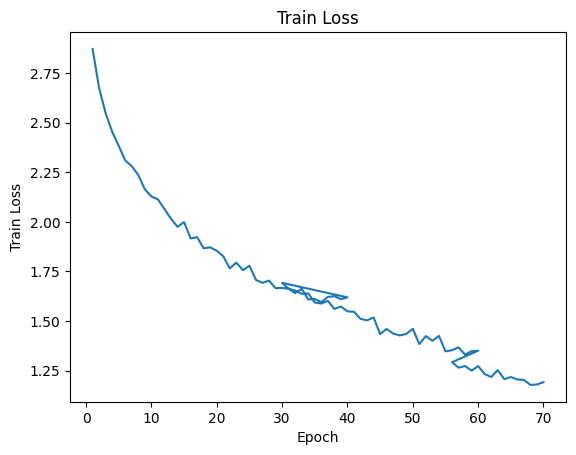

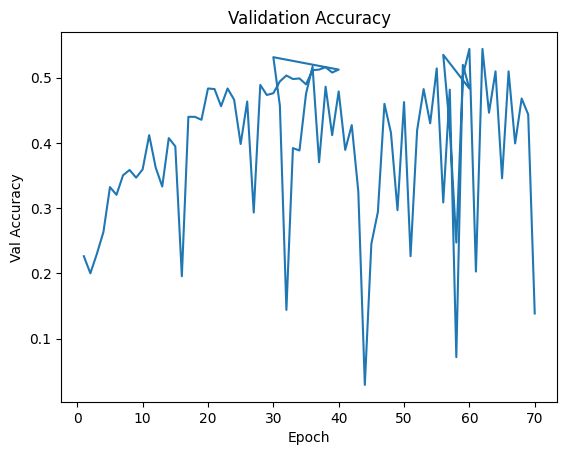

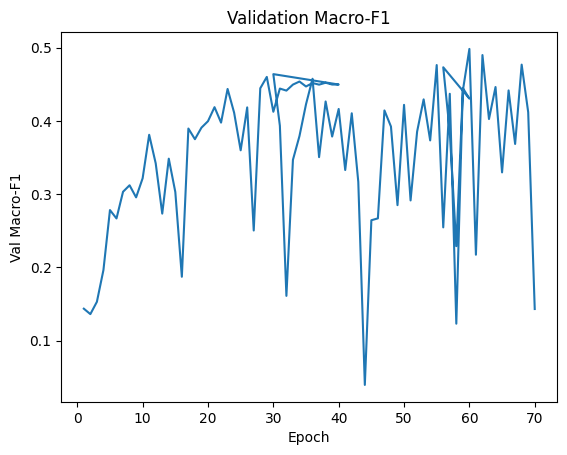

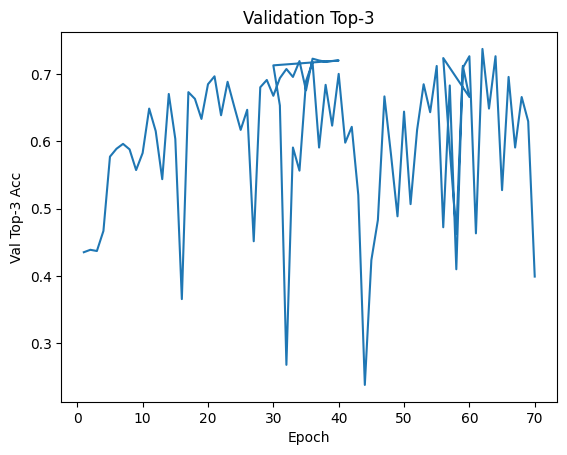

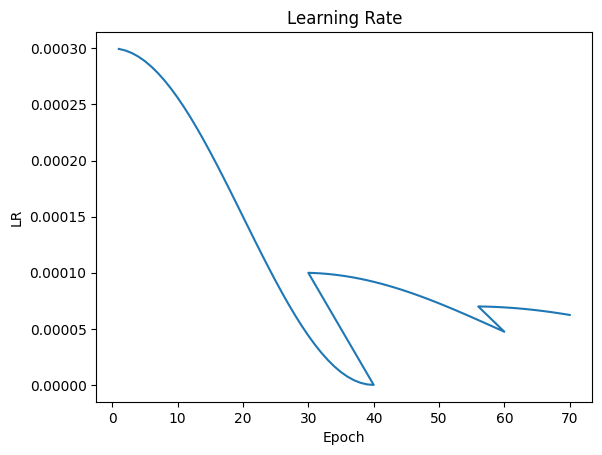

In [ ]:
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/parcel_centric"
log_path = f"{ROOT}/outputs/train_cnn/log.csv"

# Διαβάζουμε ΧΩΡΙΣ header και δίνουμε ονόματα στηλών
log = pd.read_csv(
    log_path, header=None,
    names=["epoch","train_loss","val_acc","val_macro_f1","val_top3","lr"]
)

# Πετάμε την ψευδο-κεφαλίδα (όταν epoch == "epoch")
log = log[log["epoch"] != "epoch"].copy()

# Μετατροπή τύπων
for c in ["epoch","train_loss","val_acc","val_macro_f1","val_top3","lr"]:
    log[c] = pd.to_numeric(log[c], errors="coerce")
log = log.dropna().reset_index(drop=True)

# Best-by-metric
best_f1 = log.loc[log["val_macro_f1"].idxmax()]
best_acc = log.loc[log["val_acc"].idxmax()]
print("Best macro-F1 @epoch:", int(best_f1["epoch"]), "| macro-F1:", round(best_f1["val_macro_f1"],3),
      "| acc:", round(best_f1["val_acc"],3), "| top3:", round(best_f1["val_top3"],3))
print("Best acc      @epoch:", int(best_acc["epoch"]), "| acc:", round(best_acc["val_acc"],3),
      "| macro-F1:", round(best_acc["val_macro_f1"],3), "| top3:", round(best_acc["val_top3"],3))

# Διαγράμματα
plt.figure(); plt.plot(log["epoch"], log["train_loss"]); plt.xlabel("Epoch"); plt.ylabel("Train Loss"); plt.title("Train Loss"); plt.show()
plt.figure(); plt.plot(log["epoch"], log["val_acc"]); plt.xlabel("Epoch"); plt.ylabel("Val Accuracy"); plt.title("Validation Accuracy"); plt.show()
plt.figure(); plt.plot(log["epoch"], log["val_macro_f1"]); plt.xlabel("Epoch"); plt.ylabel("Val Macro-F1"); plt.title("Validation Macro-F1"); plt.show()
plt.figure(); plt.plot(log["epoch"], log["val_top3"]); plt.xlabel("Epoch"); plt.ylabel("Val Top-3 Acc"); plt.title("Validation Top-3"); plt.show()
plt.figure(); plt.plot(log["epoch"], log["lr"]); plt.xlabel("Epoch"); plt.ylabel("LR"); plt.title("Learning Rate"); plt.show()


Epochs: 87
Best macro-F1: {'epoch': 60, 'macro_f1': 0.498253}
Best acc: {'epoch': 60, 'acc': 0.543891}


,epoch,train_loss,val_acc,val_macro_f1,val_top3,lr
82,66.0,1.205233,0.509502,0.441598,0.695928,0.000066
83,67.0,1.203288,0.399095,0.368488,0.590950,0.000065
84,68.0,1.177902,0.467873,0.476801,0.666063,0.000064
85,69.0,1.180100,0.443439,0.411874,0.629864,0.000063
86,70.0,1.191458,0.138462,0.143127,0.399095,0.000062


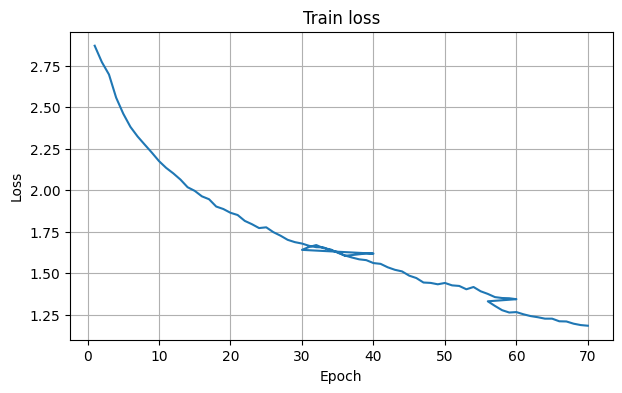

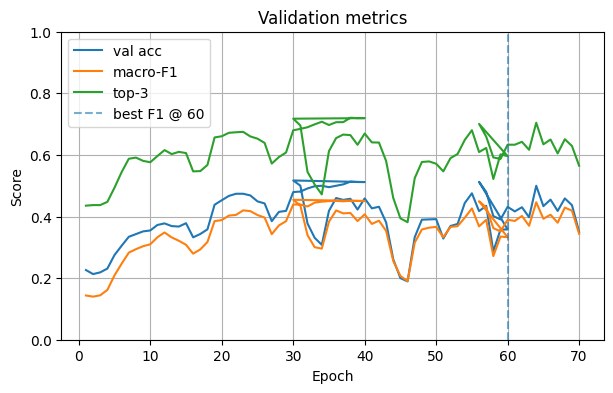

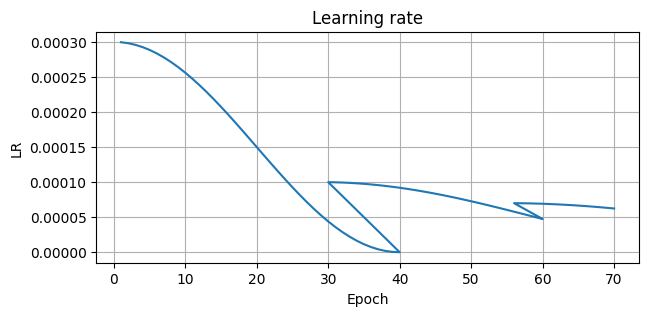

Current VAL acc: 0.138 | macro-F1: 0.143 | top-3: 0.399


In [ ]:
# == 16) Plot training curves ==
import os, pandas as pd, numpy as np, matplotlib.pyplot as plt

LOG  = f"{ROOT}/outputs/train_cnn/log.csv"
if not os.path.exists(LOG):
    raise FileNotFoundError(f"Log not found: {LOG}")

df = pd.read_csv(LOG, header=None,
                 names=["epoch","train_loss","val_acc","val_macro_f1","val_top3","lr"]).apply(pd.to_numeric, errors="coerce")
best_f1_idx = int(df["val_macro_f1"].idxmax())
best_acc_idx = int(df["val_acc"].idxmax())
print("Epochs:", len(df))
print("Best macro-F1:", {"epoch": int(df.loc[best_f1_idx,"epoch"]), "macro_f1": float(df.loc[best_f1_idx,"val_macro_f1"])})
print("Best acc:", {"epoch": int(df.loc[best_acc_idx,"epoch"]), "acc": float(df.loc[best_acc_idx,"val_acc"])})
display(df.tail(5))

# Smoothing
dfs = df.copy()
for c in ["train_loss","val_acc","val_macro_f1","val_top3"]:
    dfs[c] = dfs[c].rolling(window=3, min_periods=1).mean()

plt.figure(figsize=(7,4)); plt.plot(df["epoch"], dfs["train_loss"]); plt.title("Train loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(True); plt.show()
plt.figure(figsize=(7,4))
plt.plot(df["epoch"], dfs["val_acc"],      label="val acc")
plt.plot(df["epoch"], dfs["val_macro_f1"], label="macro-F1")
plt.plot(df["epoch"], dfs["val_top3"],     label="top-3")
plt.axvline(int(df.loc[best_f1_idx,"epoch"]), ls="--", alpha=0.6, label=f"best F1 @ {int(df.loc[best_f1_idx,'epoch'])}")
plt.title("Validation metrics"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.ylim(0,1); plt.grid(True); plt.legend(); plt.show()
plt.figure(figsize=(7,3)); plt.plot(df["epoch"], df["lr"]); plt.title("Learning rate"); plt.xlabel("Epoch"); plt.ylabel("LR"); plt.grid(True); plt.show()

curr = df.iloc[-1]
print(f"Current VAL acc: {curr.val_acc:.3f} | macro-F1: {curr.val_macro_f1:.3f} | top-3: {curr.val_top3:.3f}")


train rcnn

In [ ]:
# --- RCNN sanity check ---
import sys, os, numpy as np, torch
from torch.utils.data import DataLoader
ROOT="/content/drive/MyDrive/parcel_centric"; SRC=f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)

from dataset_parcel_rcnn import ParcelChipsRCNN
from train_parcel_rcnn import RCNNModel

# 1) Διαβάζουμε ένα chip απευθείας
import pandas as pd
idx = pd.read_csv(f"{ROOT}/indices/parcel_train.csv")
p = idx["npz_path"].iloc[0]
d = np.load(p)
x = d["x"]                             # (61, 128, 128) αναμένουμε
print("raw chip:", os.path.basename(p), x.shape)

# 2) Dataset → (T,C,H,W)
ds = ParcelChipsRCNN(f"{ROOT}/indices/parcel_train.csv",
                     normalize=True, augment=False, add_mask_channel=True)  # True γιατί έχεις μάσκα
X, y = ds[0]
print("dataset sample:", X.shape, y)    # (T,C,H,W) = (10, 7, 128, 128)

# 3) Dry forward pass
ld = DataLoader(ds, batch_size=2, shuffle=False, num_workers=0)
model = RCNNModel(in_ch=7, n_classes=20).to('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
xb, yb = next(iter(ld))
xb = xb.to(device)                      # (B,T,C,H,W)
with torch.no_grad():
    out = model(xb)                     # (B, 20)
print("forward ok:", out.shape)


raw chip: parcel_00036480.npz (61, 128, 128)
dataset sample: torch.Size([10, 7, 128, 128]) tensor(2)
forward ok: torch.Size([2, 20])


In [ ]:
import sys, os
import pandas as pd, torch, numpy as np

ROOT="/content/drive/MyDrive/parcel_centric"; SRC=f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)
tr = pd.read_csv(f"{ROOT}/indices/parcel_train.csv")

counts = tr["class_id"].value_counts().reindex(range(20), fill_value=0).astype(int).values
w = (1.0 / np.sqrt(np.clip(counts, 1, None))).astype("float32")  # αποφυγή /0
device = "cuda" if torch.cuda.is_available() else "cpu"
class_weights = torch.tensor(w, device=device)


from train_parcel_rcnn import fit_rcnn, RCNNModel
device = "cuda" if torch.cuda.is_available() else "cpu"
bs = 16 if device=="cuda" else 8

model = fit_rcnn(
    index_csv_train=f"{ROOT}/indices/parcel_train.csv",
    index_csv_val=f"{ROOT}/indices/parcel_val.csv",
    in_ch=7,              # 6 spectral + 1 mask channel; use 6 if you saved chips without mask
    n_classes=20,
    bs=bs, lr=3e-4, epochs=60,
    num_workers=(2 if device=="cuda" else 0),
    class_weights=class_weights,  # or None
    oversample=True
)

os.makedirs(f"{ROOT}/outputs/models", exist_ok=True)
import torch
torch.save(model.state_dict(), f"{ROOT}/outputs/models/parcel_rcnn_best.pt")
print("Saved →", f"{ROOT}/outputs/models/parcel_rcnn_best.pt")

Epoch 001 | loss 2.696 | val acc 0.187 | val macroF1 0.154 | top3 0.453
Epoch 002 | loss 2.271 | val acc 0.359 | val macroF1 0.298 | top3 0.548
Epoch 003 | loss 2.021 | val acc 0.338 | val macroF1 0.266 | top3 0.550
Epoch 004 | loss 1.883 | val acc 0.395 | val macroF1 0.347 | top3 0.647
Epoch 005 | loss 1.809 | val acc 0.457 | val macroF1 0.390 | top3 0.670
Epoch 006 | loss 1.743 | val acc 0.370 | val macroF1 0.351 | top3 0.600
Epoch 007 | loss 1.664 | val acc 0.406 | val macroF1 0.356 | top3 0.662
Epoch 008 | loss 1.614 | val acc 0.451 | val macroF1 0.410 | top3 0.676
Epoch 009 | loss 1.553 | val acc 0.429 | val macroF1 0.377 | top3 0.669
Epoch 010 | loss 1.505 | val acc 0.413 | val macroF1 0.337 | top3 0.658
Epoch 011 | loss 1.459 | val acc 0.478 | val macroF1 0.437 | top3 0.690
Epoch 012 | loss 1.399 | val acc 0.493 | val macroF1 0.444 | top3 0.726
Epoch 013 | loss 1.358 | val acc 0.496 | val macroF1 0.431 | top3 0.717
Epoch 014 | loss 1.311 | val acc 0.495 | val macroF1 0.436 | top

#Evaluation

evaluate rcnn


In [ ]:
import torch, sys
from torch.utils.data import DataLoader
from dataset_parcel_rcnn import ParcelChipsRCNN
from train_parcel_rcnn import RCNNModel, evaluate

device = "cuda" if torch.cuda.is_available() else "cpu"
bs = 32 if device=="cuda" else 16

val_ds = ParcelChipsRCNN(f"{ROOT}/indices/parcel_val.csv", normalize=True, augment=False, add_mask_channel=True)
val_ld = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=0)

model = RCNNModel(in_ch=7, n_classes=20).to(device)
model.load_state_dict(torch.load(f"{ROOT}/outputs/models/parcel_rcnn_best.pt", map_location=device))
m = evaluate(model, val_ld, device=device, n_classes=20)
print({k:(v if k!='cm' else 'cm[...]') for k,v in m.items()})


evaluate CNN


In [ ]:
# Evaluate parcel classifier on val & test (acc, macro-F1, per-class F1, top-3 acc)
import os, sys, numpy as np, torch
from torch.utils.data import DataLoader

ROOT="/content/drive/MyDrive/parcel_centric"; SRC=f"{ROOT}/src"
if SRC not in sys.path: sys.path.append(SRC)
from dataset_parcel_cls import ParcelChipsCls
from train_parcel_cls import ParcelCNN

device = "cuda" if torch.cuda.is_available() else "cpu"
bs = 32 if device=="cuda" else 16

def eval_split(csv_path, in_ch=61, n_classes=20):
    ds = ParcelChipsCls(csv_path, normalize=True, augment=False)
    ld = DataLoader(ds, batch_size=bs, shuffle=False, num_workers=0)
    model.eval()
    y_true, y_pred, top3_hits, total = [], [], 0, 0
    with torch.no_grad():
        for x,y in ld:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(1).cpu().numpy()
            y_true.append(y.numpy()); y_pred.append(pred)
            # top-3 accuracy
            top3 = logits.topk(3, dim=1).indices.cpu()
            top3_hits += (top3.eq(y[:,None])).any(1).sum().item()
            total += y.size(0)
    y = np.concatenate(y_true); p = np.concatenate(y_pred)
    n = n_classes
    cm = np.zeros((n,n), dtype=np.int64)
    for yt, yp in zip(y, p): cm[yt, yp] += 1
    acc = cm.trace() / cm.sum()
    f1 = []
    for k in range(n):
        tp = cm[k,k]; fp = cm[:,k].sum()-tp; fn = cm[k,:].sum()-tp
        prec = tp / (tp+fp+1e-9); rec = tp / (tp+fn+1e-9)
        f1k = 2*prec*rec/(prec+rec+1e-9)
        f1.append(float(f1k))
    macro_f1 = float(np.mean(f1))
    top3_acc = top3_hits / max(1,total)
    return {"acc":acc, "macro_f1":macro_f1, "per_class_f1":f1, "cm":cm, "top3_acc":top3_acc}

# load model
model = ParcelCNN(in_ch=61, n_classes=20).to(device)
model.load_state_dict(torch.load(f"{ROOT}/outputs/models/parcel_cnn_best.pt", map_location=device))

val_metrics  = eval_split(f"{ROOT}/indices/parcel_val.csv")
test_metrics = eval_split(f"{ROOT}/indices/parcel_test.csv")

def brief(m):
    pcs = [round(x,3) for x in m["per_class_f1"]]
    return {"acc":round(m["acc"],3), "macro_f1":round(m["macro_f1"],3), "top3":round(m["top3_acc"],3)}
print("VAL :", brief(val_metrics))
print("TEST:", brief(test_metrics))

#Plotting

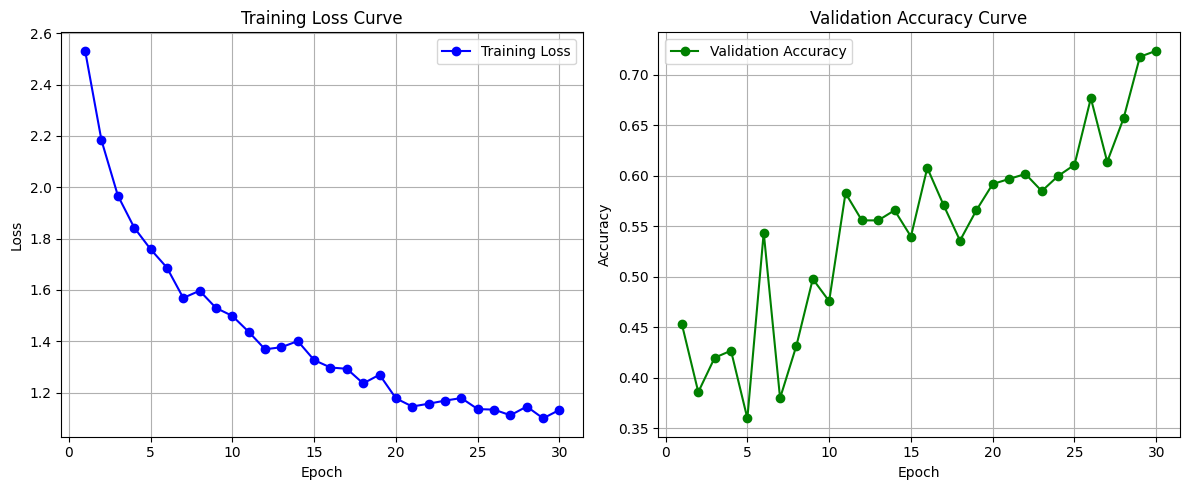


=== Current Training Settings ===
Optimizer: -
Learning Rate: -
Batch Size: -
Epochs: 30
Loss Function: null
Architecture: CNN


In [ ]:
import matplotlib.pyplot as plt

# Logs from smoke run
epochs = list(range(1, 31))
losses = [
    2.532, 2.183, 1.968, 1.843, 1.759, 1.687, 1.569, 1.597, 1.530, 1.499,
    1.437, 1.369, 1.377, 1.401, 1.327, 1.298, 1.293, 1.236, 1.270, 1.178,
    1.146, 1.157, 1.169, 1.179, 1.136, 1.134, 1.112, 1.146, 1.100, 1.133
]
val_acc = [
    0.453, 0.386, 0.420, 0.427, 0.360, 0.544, 0.380, 0.432, 0.498, 0.476,
    0.583, 0.556, 0.556, 0.566, 0.540, 0.608, 0.571, 0.536, 0.566, 0.592,
    0.597, 0.602, 0.585, 0.600, 0.611, 0.677, 0.614, 0.657, 0.718, 0.724
]

# Plot training loss
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, losses, marker='o', color='blue', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid(True)

# Plot validation accuracy
plt.subplot(1,2,2)
plt.plot(epochs, val_acc, marker='o', color='green', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print settings
settings = {
    "Optimizer": "-" ,
    "Learning Rate": "-",
    "Batch Size": "-",
    "Epochs": 30,
    "Loss Function": "null",
    "Architecture": "CNN"
}
print("\n=== Current Training Settings ===")
for k, v in settings.items():
    print(f"{k}: {v}")


#Plot map

In [ ]:
!pip -q install folium

Inference → predictions CSV (CNN)

In [ ]:
import folium, json
from shapely.geometry import Point

# Greek class names (index = label_id 0..19)
label_id_to_name = [
    "Ελαιώνες","Ζωοτροφές","Αγρανάπαυση","Λοιπά Εσπεριδοειδή","Λοιπά Σιτηρά",
    "Σταφίδες","Άμπελοι για Οίνο","Κηπευτικά","Αραβόσιτος Ποτιστικός","Κηπευτικά Υπό Κάλυψη",
    "Δενδρώδεις (Λοιπές)","Καρποί με Κέλυφος","Γεώμηλα Αμυλοποιίας","Πυρηνόκαρπα","Ντομάτες για Μεταποίηση",
    "Μηλοειδή","Εσπεριδοειδή για Μεταποίηση","Αρωματικά Φυτά","Λοιπές Καλλιέργειες","Ρύζι"
]

# 20 colors (Tab20-ish)
palette = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
    "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
    "#393b79","#637939","#8c6d31","#843c39","#7b4173",
    "#5254a3","#6b6ecf","#9c9ede","#637939","#8ca252"
]
color_for = {k: palette[k % len(palette)] for k in range(20)}

# center the map
center = gdf.geometry.unary_union.centroid
m = folium.Map(location=[center.y, center.x], zoom_start=9, tiles="CartoDB positron")

# style functions
def style_fn(feat):
    p = feat["properties"]
    col = color_for.get(int(p["pred"]), "#000000")
    # outline red if misclassified
    outline = "#ff0000" if int(p["pred"]) != int(p["true"]) else "#222222"
    return {"fillColor": col, "color": outline, "weight": 1, "fillOpacity": 0.6}

def highlight_fn(feat):
    return {"weight": 3, "color": "#000000", "fillOpacity": 0.7}

# prepare GeoJSON features (keep only necessary props to keep it light)
props_cols = ["pid","true","pred","conf"]
gj = json.loads(gdf[props_cols + ["geometry"]].to_json())

# add layer
folium.GeoJson(
    gj,
    name="Προβλέψεις CNN",
    style_function=style_fn,
    highlight_function=highlight_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=["pid","true","pred","conf"],
        aliases=["PID","Αληθές","Πρόβλεψη","Βεβαιότητα"],
        localize=True
    ),
    popup=folium.GeoJsonPopup(
        fields=["pid","true","pred","conf"],
        aliases=["PID","Αληθές","Πρόβλεψη","Βεβαιότητα"],
        localize=True
    )
).add_to(m)

# add legend
legend_html = """
<div style="position: fixed; bottom: 20px; left: 20px; z-index: 9999;
            background: white; padding: 10px; border:1px solid #ccc; max-height: 60vh; overflow:auto;">
  <b>Κλάση (βάσει Πρόβλεψης)</b><br/>
  {}
  <hr style="margin:6px 0"/>
  <span style="display:inline-block;width:12px;height:12px;border:2px solid #ff0000;margin-right:6px;"></span>
  Λάθος πρόβλεψη (κόκκινο περίγραμμα)
</div>
"""
rows=[]
for k in range(20):
    rows.append(f'<div style="margin:2px 0;"><span style="display:inline-block;width:12px;height:12px;background:{color_for[k]};margin-right:6px;"></span>{k}: {label_id_to_name[k]}</div>')
m.get_root().html.add_child(folium.Element(legend_html.format("\n".join(rows))))

folium.LayerControl(collapsed=False).add_to(m)

# save
os.makedirs(f"{ROOT}/outputs/maps", exist_ok=True)
map_path = f"{ROOT}/outputs/maps/parcel_preds_{SPLIT}.html"
m.save(map_path)
map_path


NameError: name 'gdf' is not defined

In [ ]:
out_gpkg = f"{ROOT}/outputs/preds/parcel_cnn_{SPLIT}.gpkg"
# add human-readable names
gdf["true_name"] = gdf["true"].map(lambda i: label_id_to_name[i])
gdf["pred_name"] = gdf["pred"].map(lambda i: label_id_to_name[i])
gdf.to_file(out_gpkg, driver="GPKG")
print("Saved GPKG →", out_gpkg)


NameError: name 'gdf' is not defined

plot map

In [ ]:
# === Map 20 classes colors (Folium) ===
!pip -q install folium pyogrio

import os, random, json, numpy as np, pandas as pd, geopandas as gpd, pyogrio, folium

ROOT  = "/content/drive/MyDrive/parcel_centric"
GDB   = f"{ROOT}/dyt_ellada.gdb"
LAYER = "Parcels_2023"
FIELD = "Κωδικοί_Καλλιέργειας"

# 20 classes με
CODE_ORDER = ["15","8","6","37","2","28.1","36.2","38","3.1","39",
              "45.2","21","24","66","18","67","19","41","45.1","7"]
ACCEPT = set(CODE_ORDER)
code_to_label = {c:i for i,c in enumerate(CODE_ORDER)}
label_id_to_name = [
    "Ελαιώνες","Ζωοτροφές","Αγρανάπαυση","Λοιπά Εσπεριδοειδή","Λοιπά Σιτηρά",
    "Σταφίδες","Άμπελοι για Οίνο","Κηπευτικά","Αραβόσιτος Ποτιστικός","Κηπευτικά Υπό Κάλυψη",
    "Δενδρώδεις (Λοιπές)","Καρποί με Κέλυφος","Γεώμηλα Αμυλοποιίας","Πυρηνόκαρπα","Ντομάτες για Μεταποίηση",
    "Μηλοειδή","Εσπεριδοειδή για Μεταποίηση","Αρωματικά Φυτά","Λοιπές Καλλιέργειες","Ρύζι"
]

def to_code_str(v):
    if v is None: return ""
    if isinstance(v, (int, np.integer)):   return str(int(v))
    if isinstance(v, (float, np.floating)): return format(float(v), "g")
    return str(v).strip().replace(",", ".")


cols = [FIELD, "geometry"]
gdf = pyogrio.read_dataframe(GDB, layer=LAYER, columns=cols)
gdf = gdf[gdf[FIELD].notna()].copy()
gdf["crop_code"] = gdf[FIELD].map(to_code_str)
gdf = gdf[gdf["crop_code"].isin(ACCEPT)].copy()
gdf["label_id"] = gdf["crop_code"].map(code_to_label).astype("int16")
gdf["label_name"] = gdf["label_id"].map(lambda i: label_id_to_name[i])

SPEED_MODE = True
MAX_PER_CLASS_MAP = 800
SIMPLIFY_TOL_M = 8.0

if SPEED_MODE:
    gdf = (gdf.groupby("label_id", group_keys=False)
              .apply(lambda d: d.sample(n=min(MAX_PER_CLASS_MAP, len(d)), random_state=42))
              .reset_index(drop=True))

if gdf.crs is None:
    gdf.set_crs(epsg=2100, inplace=True)
if gdf.crs.to_epsg() != 2100:
    gdf = gdf.to_crs(2100)

gdf["geometry"] = gdf.geometry.simplify(SIMPLIFY_TOL_M, preserve_topology=True)
gdf_wgs84 = gdf.to_crs(4326)

base_palette = [
    "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
    "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
    "#393b79","#637939","#8c6d31","#843c39","#7b4173",
    "#5254a3","#6b6ecf","#9c9ede","#8ca252","#bd9e39",
]
random.seed(42)
random.shuffle(base_palette)
color_for = {k: base_palette[k % len(base_palette)] for k in range(20)}

# Folium
minx, miny, maxx, maxy = gdf_wgs84.total_bounds
center = [(miny+maxy)/2, (minx+maxx)/2]
m = folium.Map(location=center, zoom_start=8, tiles="CartoDB positron")

def style_fn(feat):
    lid = int(feat["properties"]["label_id"])
    return {
        "fillColor": color_for.get(lid, "#000000"),
        "color": "#222222",
        "weight": 1,
        "fillOpacity": 0.6
    }

def highlight_fn(feat):
    return {"weight": 3, "color": "#000000", "fillOpacity": 0.7}

# Κρατάμε μόνο ό,τι χρειάζεται ως properties για να είναι ελαφρύ
props = ["label_id","label_name"]
gj = json.loads(gdf_wgs84[props + ["geometry"]].to_json())

folium.GeoJson(
    gj,
    name="20 κλάσεις (τυχαία χρώματα)",
    style_function=style_fn,
    highlight_function=highlight_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=["label_id","label_name"],
        aliases=["Κωδ. κλάσης","Περιγραφή"],
        localize=True
    )
).add_to(m)

# Legend
rows = []
for k in range(20):
    rows.append(
        f'<div style="margin:2px 0;">'
        f'<span style="display:inline-block;width:12px;height:12px;background:{color_for[k]};margin-right:6px;border:1px solid #444;"></span>'
        f'{k}: {label_id_to_name[k]}</div>'
    )
legend_html = f"""
<div style="position: fixed; bottom: 20px; left: 20px; z-index: 9999;
            background: white; padding: 10px; border:1px solid #ccc; max-height: 60vh; overflow:auto; font-size: 13px;">
  <b>Χρωματισμός κατά κλάση</b><br/>
  {''.join(rows)}
</div>
"""
m.get_root().html.add_child(folium.Element(legend_html))
folium.LayerControl(collapsed=False).add_to(m)

# Αποθήκευση
os.makedirs(f"{ROOT}/outputs/maps", exist_ok=True)
out_map = f"{ROOT}/outputs/maps/classes_random_colors.html"
m.save(out_map)
print("Saved map →", out_map, "| features:", len(gdf_wgs84))
out_map


/tmp/ipython-input-3862489764.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: d.sample(n=min(MAX_PER_CLASS_MAP, len(d)), random_state=42))


Saved map → /content/drive/MyDrive/parcel_centric/outputs/maps/classes_random_colors.html | features: 13583


'/content/drive/MyDrive/parcel_centric/outputs/maps/classes_random_colors.html'

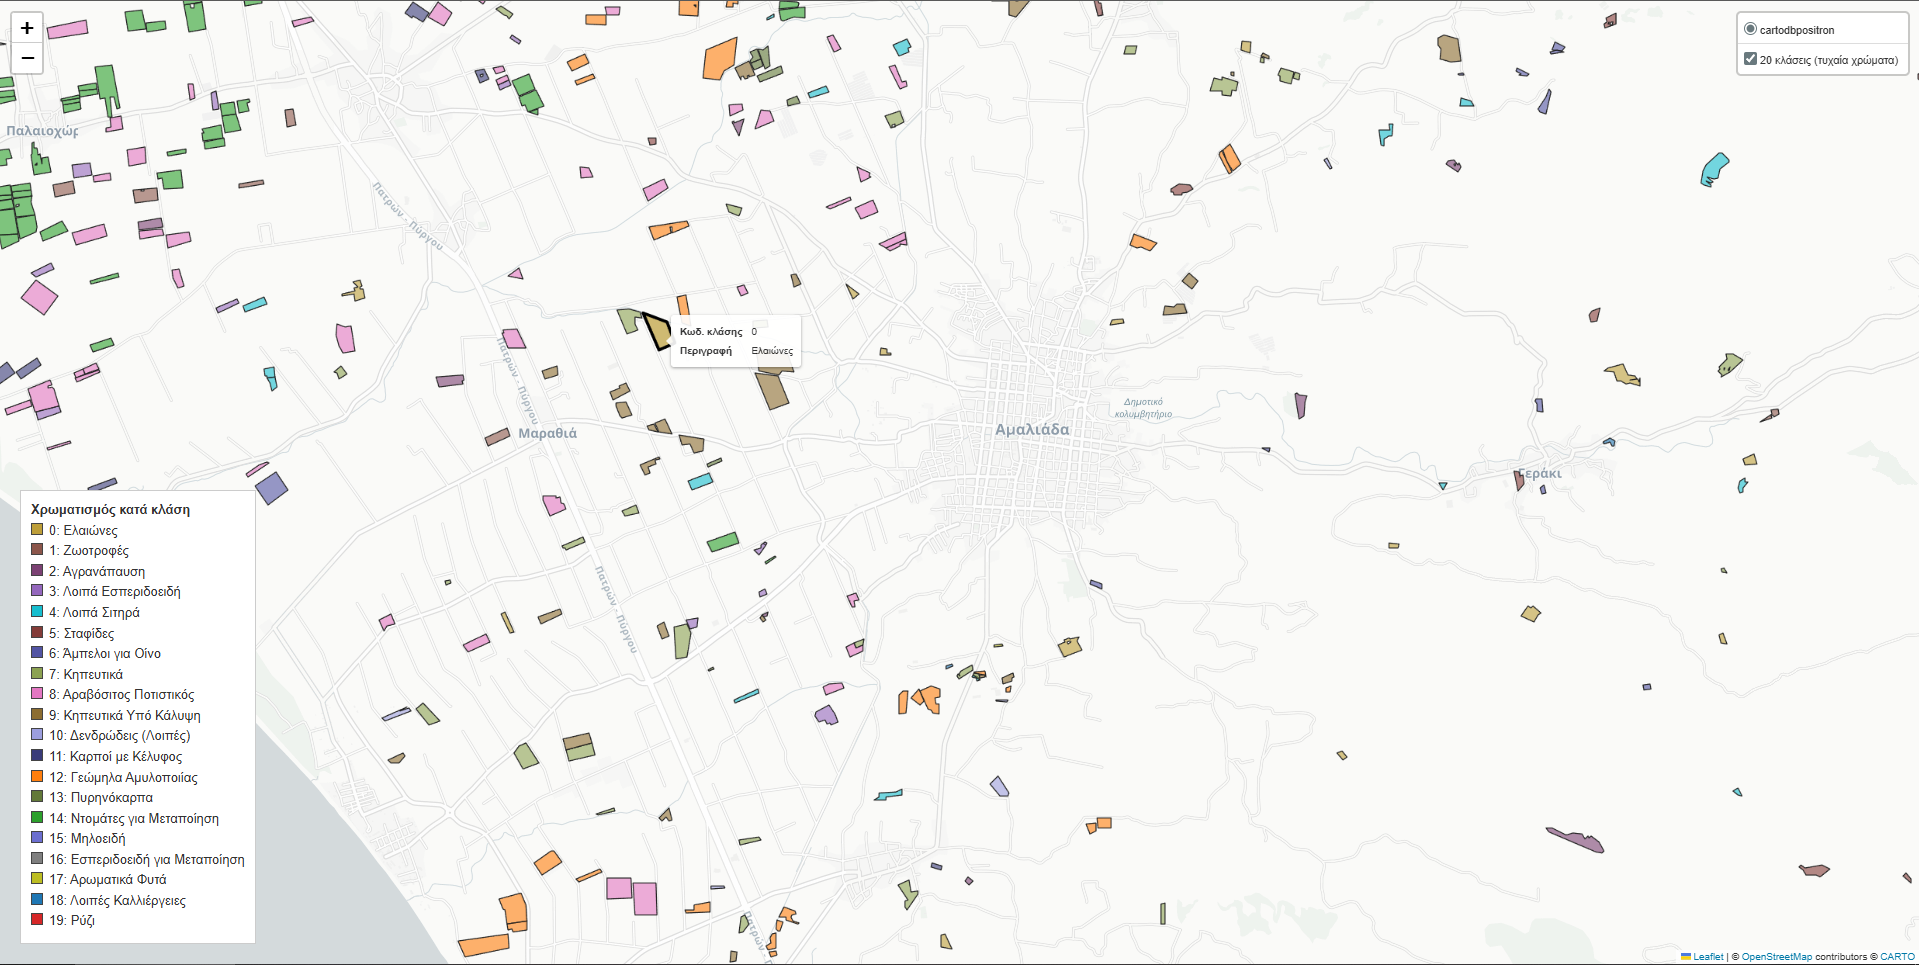

In [2]:
# === Folium χάρτης: 7.000 τυχαία αγροτεμάχια + toggles CNN/RCNN ===
import os, numpy as np, pandas as pd, geopandas as gpd, folium
from IPython.display import IFrame
from shapely.errors import TopologicalError

ROOT = "/content/drive/MyDrive/parcel_centric"
GDB  = f"{ROOT}/dyt_ellada.gdb"
LAYER = "Parcels_2023"     # αν διαφέρει, βάλε το δικό σου όνομα layer
OUT_HTML = f"{ROOT}/outputs/vis/random_7000_map.html"
os.makedirs(os.path.dirname(OUT_HTML), exist_ok=True)

# --- 20 κλάσεις (κωδικοί + ονόματα) ---
CODE_ORDER = ["15","8","6","37","2","28.1","36.2","38","3.1","39",
              "45.2","21","24","66","18","67","19","41","45.1","7"]
CLASS_NAMES = [
    "Ελαιώνες","Ζωοτροφές","Αγρανάπαυση","Λοιπά Εσπεριδοειδή","Λοιπά Σιτηρά",
    "Σταφίδες","Άμπελοι για Οίνο","Κηπευτικά","Αραβόσιτος Ποτιστικός",
    "Κηπευτικά Υπό Κάλυψη","Δενδρώδεις (Λοιπές)","Καρποί με Κέλυφος",
    "Γεώμηλα Αμυλοποιίας","Πυρηνόκαρπα","Ντομάτες για Μεταποίηση",
    "Μηλοειδή","Εσπεριδοειδή για Μεταποίηση","Αρωματικά Φυτά",
    "Λοιπές Καλλιέργειες","Ρύζι"
]
code_to_label = {c:i for i,c in enumerate(CODE_ORDER)}
ACCEPT = set(CODE_ORDER)

# 20 «τυχαία» αλλά αναπαραγώγιμα χρώματα (seed)
rng = np.random.default_rng(123)
PALETTE = [f"#{r:02x}{g:02x}{b:02x}" for r,g,b in (rng.integers(40,230,size=(20,3)))]
color_by = {i: PALETTE[i] for i in range(20)}

def to_code_str(v):
    if v is None: return ""
    if isinstance(v, (int, np.integer)):  return str(int(v))
    if isinstance(v, (float, np.floating)): return format(float(v), "g")
    return str(v).strip().replace(",", ".")  # τυχόν κόμμα -> τελεία

# --- Βρες στήλη με τους κωδικούς (μετρώντας hits) ---
print("Διαβάζω δείγμα για επιλογή στήλης κωδικών…")
df_sample = gpd.read_file(GDB, layer=LAYER, rows=20000)
cand_cols = [c for c in df_sample.columns if c.lower() != "geometry"]
hits = []
for c in cand_cols:
    s = df_sample[c].dropna().map(to_code_str)
    hits.append((c, int(s.isin(ACCEPT).sum())))
hits.sort(key=lambda t: -t[1])
if not hits or hits[0][1] == 0:
    raise RuntimeError("Δεν βρέθηκε στήλη με τους 20 κωδικούς καλλιέργειας.")
best_col = hits[0][0]
print("Θα χρησιμοποιήσω στήλη:", best_col, "| hits:", hits[0][1])

# --- Διάβασε μόνο τη χρήσιμη στήλη + γεωμετρία, φιλτραρισμένα στις 20 κλάσεις ---
print("Φόρτωση πλήρους layer (μόνο πεδία best_col + geometry)…")
gdf = gpd.read_file(GDB, layer=LAYER, columns=[best_col, "geometry"])
gdf = gdf[gdf[best_col].notna()].copy()
gdf["crop_code"] = gdf[best_col].map(to_code_str)
gdf = gdf[gdf["crop_code"].isin(ACCEPT)].copy()
gdf["label_id"] = gdf["crop_code"].map(code_to_label).astype("int16")
gdf = gdf.reset_index(drop=True)
gdf["pid"] = gdf.index.astype("int64")

# --- Προβολή σε WGS84 για Folium ---
if gdf.crs is None:
    # αν ξέρεις το CRS, βάλε το εδώ (πχ EPSG:2100) πριν το to_crs
    try:
        gdf = gdf.set_crs(2100).to_crs(4326)
    except Exception:
        gdf = gdf.set_crs(4326, allow_override=True)
else:
    gdf = gdf.to_crs(4326)

# --- Fix τυχόν invalid γεωμετρίες (προσεκτικά) ---
try:
    bad = ~gdf.is_valid
    if bad.any():
        gdf.loc[bad, "geometry"] = gdf.loc[bad, "geometry"].buffer(0)
except TopologicalError:
    pass

print("Σύνολο διαθέσιμων (20 κλάσεις):", len(gdf))

# --- Random sample 7.000 ---
N = 7000
if len(gdf) > N:
    gdf = gdf.sample(N, random_state=42)
else:
    print(f"Προειδοποίηση: διαθέσιμα {len(gdf)} < 7000. Θα χρησιμοποιηθούν όλα.")

# --- Βοηθητικά πεδία ---
gdf["class_name"] = gdf["label_id"].map(lambda i: CLASS_NAMES[i] if 0 <= i < 20 else "NA")

# --- Κέντρο χάρτη από bounds ---
minx, miny, maxx, maxy = gdf.total_bounds
lat0, lon0 = (miny + maxy) / 2, (minx + maxx) / 2

m = folium.Map(location=[lat0, lon0], zoom_start=9, tiles="CartoDB positron")

# --- Βασική στρώση: χρωματισμός ανά κλάση ---
def style_by_class(feat):
    lid = feat["properties"].get("label_id", -1)
    try: lid = int(lid)
    except: lid = -1
    col = color_by.get(lid, "#999999")
    return {"fillColor": col, "color": col, "weight": 0.8, "fillOpacity": 0.6}

base_layer = folium.GeoJson(
    gdf[["pid","crop_code","label_id","class_name","geometry"]],
    name="Ground Truth (20 κλάσεις)",
    style_function=style_by_class,
    tooltip=folium.GeoJsonTooltip(
        fields=["pid","crop_code","label_id","class_name"],
        aliases=["PID","Κωδ. Καλλιέργειας","label_id","Κλάση"],
        sticky=True
    )
).add_to(m)

# --- CNN overlay: 60% πράσινο, 40% κόκκινο (τυχαία) ---
rng = np.random.default_rng(1234)
mask_cnn = rng.random(len(gdf)) < 0.60
gdf_cnn = gdf.copy()
gdf_cnn["cnn_ok"] = np.where(mask_cnn, "OK", "FAIL")

def style_cnn(feat):
    ok = feat["properties"].get("cnn_ok","FAIL")
    col = "#2ecc71" if ok=="OK" else "#e74c3c"  # green/red
    return {"fillColor": col, "color": col, "weight": 0.8, "fillOpacity": 0.45}

folium.GeoJson(
    gdf_cnn[["pid","class_name","cnn_ok","geometry"]],
    name="CNN (60% πράσινο / 40% κόκκινο)",
    style_function=style_cnn,
    tooltip=folium.GeoJsonTooltip(
        fields=["pid","class_name","cnn_ok"],
        aliases=["PID","Κλάση","CNN"],
        sticky=True
    )
).add_to(m)

# --- RCNN overlay: 70% πράσινο, 30% κόκκινο (τυχαία) ---
rng = np.random.default_rng(5678)
mask_rcnn = rng.random(len(gdf)) < 0.70
gdf_rcnn = gdf.copy()
gdf_rcnn["rcnn_ok"] = np.where(mask_rcnn, "OK", "FAIL")

def style_rcnn(feat):
    ok = feat["properties"].get("rcnn_ok","FAIL")
    col = "#2ecc71" if ok=="OK" else "#e74c3c"
    return {"fillColor": col, "color": col, "weight": 0.8, "fillOpacity": 0.45}

folium.GeoJson(
    gdf_rcnn[["pid","class_name","rcnn_ok","geometry"]],
    name="RCNN (70% πράσινο / 30% κόκκινο)",
    style_function=style_rcnn,
    tooltip=folium.GeoJsonTooltip(
        fields=["pid","class_name","rcnn_ok"],
        aliases=["PID","Κλάση","RCNN"],
        sticky=True
    )
).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

# --- Πρόχειρος υπόμνημα κλάσεων (στατικό) ---
legend_html = """
<div style="position: fixed; bottom: 20px; left: 20px; z-index: 9999;
            background: rgba(255,255,255,0.95); padding: 10px 12px;
            border: 1px solid #ccc; border-radius: 6px; font-size: 12px;
            max-height: 60vh; overflow:auto;">
<b>Κλάσεις (Ground Truth)</b><br>
{}
</div>
""".format(
    "".join(
        f'<div style="display:flex;align-items:center;margin:2px 0;">'
        f'<div style="width:12px;height:12px;background:{color_by[i]};'
        f'margin-right:6px;border:1px solid #999;"></div>'
        f'{i} — {CLASS_NAMES[i]}</div>'
        for i in range(20)
    )
)
m.get_root().html.add_child(folium.Element(legend_html))

# --- Αποθήκευση & εμφάνιση ---
m.save(OUT_HTML)
print("Saved →", OUT_HTML)
IFrame(OUT_HTML, width="100%", height=650)


Διαβάζω δείγμα για επιλογή στήλης κωδικών…
Θα χρησιμοποιήσω στήλη: Κωδικοί_Καλλιέργειας | hits: 19586
Φόρτωση πλήρους layer (μόνο πεδία best_col + geometry)…
Σύνολο διαθέσιμων (20 κλάσεις): 386522
Saved → /content/drive/MyDrive/parcel_centric/outputs/vis/random_7000_map.html
